# Environment

```sh
pwd; date
# /Users/cchiang/research/chiang/projects/covid-19
# Mon Apr 27 05:07:38 EDT 2020

```

## Libraries

In [495]:
# Load packages
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggthemes))
suppressPackageStartupMessages(library(reshape2))
library(tidyverse)
library(deSolve)
library(viridis)

# library(tidyverse)
# library(lubridate)
# library(rvest)
# library(stringdist)

## Options

In [1]:
options(repr.plot.width=12, repr.plot.height=8)

# Data

Data sourced from Johns Hopkins repository
https://github.com/CSSEGISandData/COVID-19

```sh

curl -s https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv \
    | gzip -c > data/jhu/time_series_covid19_deaths_global.csv.gz

curl -s https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv \
    | gzip -c > data/jhu/time_series_covid19_confirmed_global.csv.gz

```

In [316]:
# clean up data
jhu.death <- read_csv('data/jhu/time_series_covid19_deaths_global.2020-04-24.csv.gz')
gdeath <- melt(select(jhu.death,
                      'subregion'="Province/State",
                      'region'='Country/Region',
                      matches('[0-9]*/[0-9]*/[0-9]*')),
               id=c('subregion', 'region'),
               variable.name='date', value.name='death')
gdeath$region <- factor(gdeath$region)
gdeath$date <- as.Date(gdeath$date, format='%m/%d/%y')

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



Warning message:
“Ignoring unknown parameters: shape”


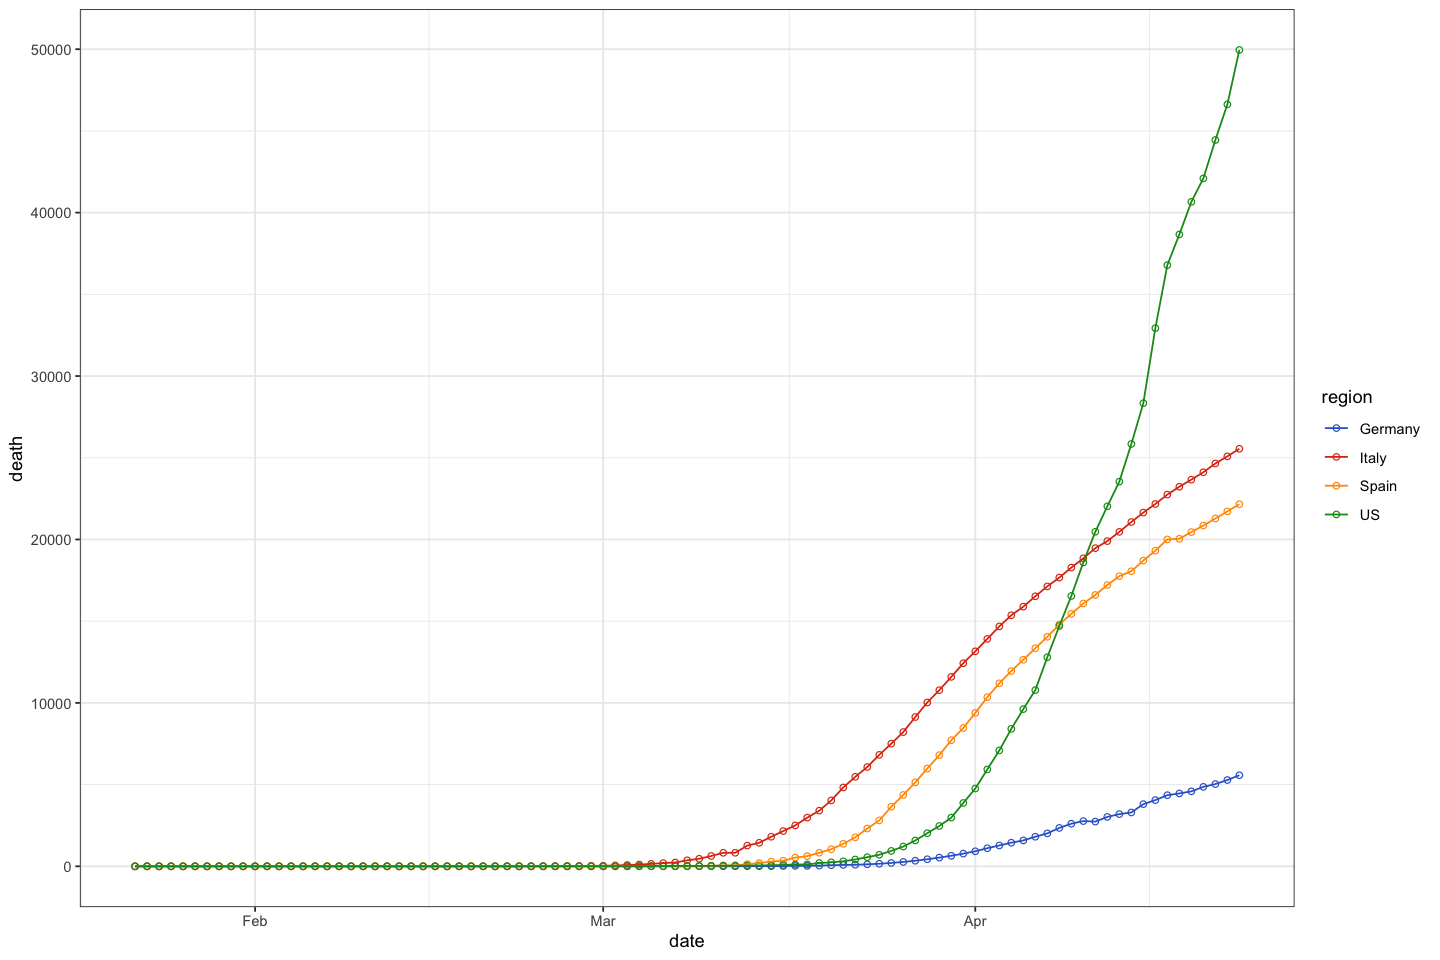

In [314]:
# plot trends in different countries

p <- ggplot(gdeath[gdeath$region %in% c('Italy', 'US', 'Germany', 'Spain'), ], aes(date, death, col=region))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_point(shape=21)
p <- p + geom_line(shape=21)
# p <- p + scale_y_continuous(trans='log10')
p

# SIR Model

Using SIR model (susceptible, infected, recovered) with additional category D = deceased. This strategy is motivated by testing shortage and unreliable case reporting data.

$$\begin{align}
\frac{dS(t)}{dt} &= -\beta I(t) S(t) \\[10pt]
\frac{dI(t)}{dt} &= \beta S(t) I(t) - (\gamma + \mu) I(t) \\[10pt]
\frac{dR(t)}{dt} &= \gamma I(t) \\[10pt]
\frac{dD(t)}{dt} &= \mu I(t)
\end{align}$$

## Fit 1: Random Guesses

##### Model

In [620]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [621]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [622]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [623]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

# time zero of virus introduction
t0 <- as.Date('2020-01-23')

##### Observed

In [624]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

In [625]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=c(beta, gamma, mu),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 29 row(s) containing missing values (geom_path).”


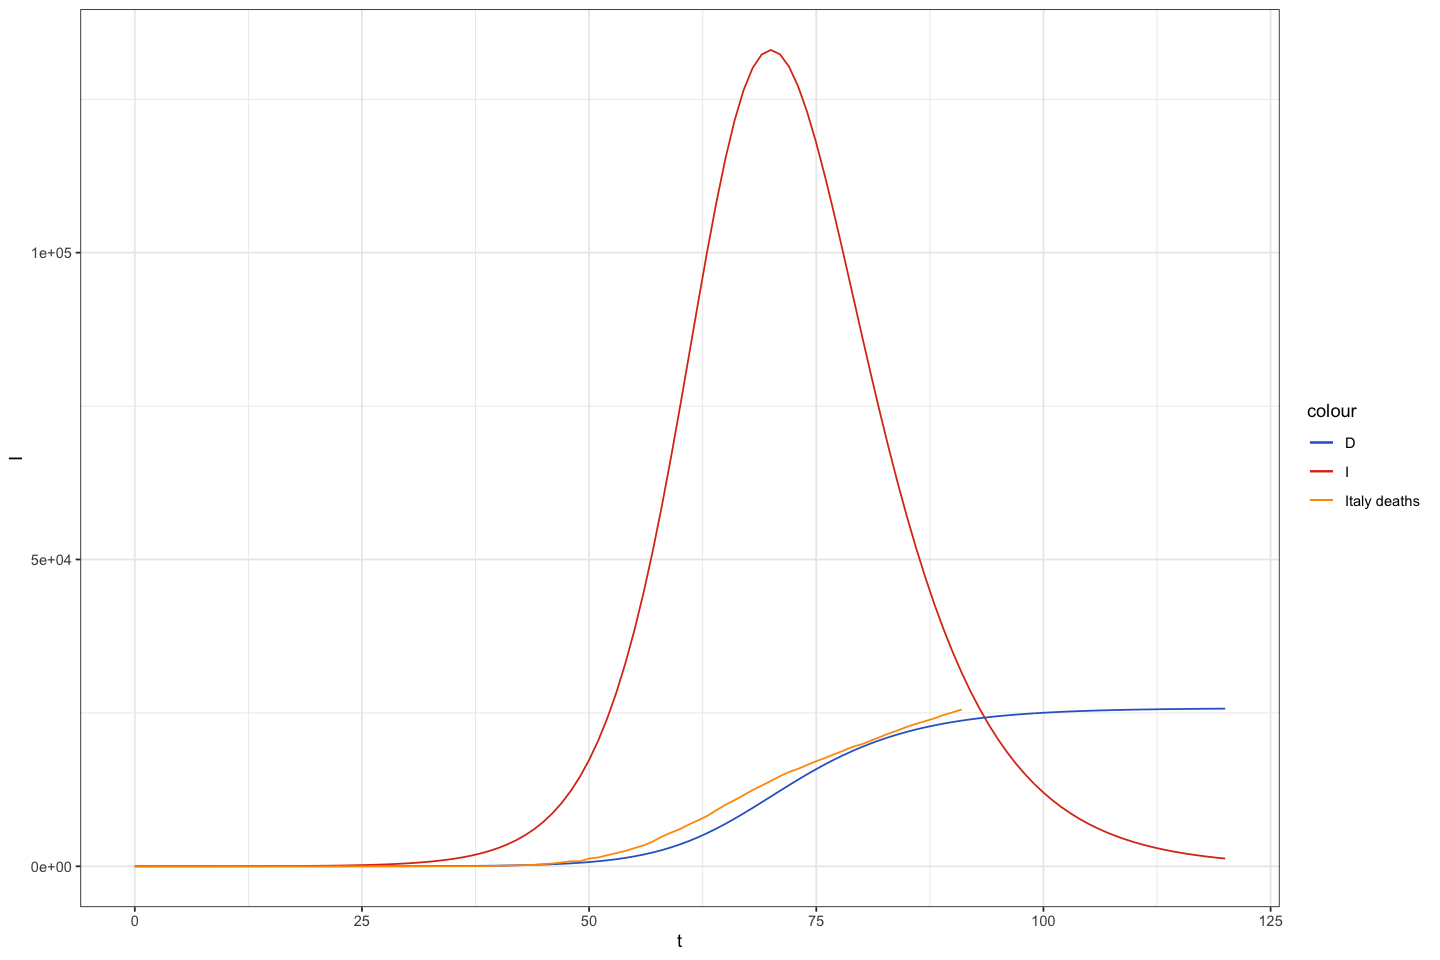

In [626]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
# p <- p + scale_y_continuous(trans='log10')
p

## Fit 2: Normal (beta optimization)

- Maximize log-likelihood (sum of normal error)
- Optimize $\beta$, fixed $\mu$ and $\gamma$

##### Model

In [382]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [383]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [384]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [385]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [386]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [387]:
# log likelihood function
loglik.normal <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dnorm(x=italy$death, mean=subset(s, t >= min(italy$t) & t <= max(italy$t))$D,
              sd=params["sigma"], log=TRUE))
}

In [616]:
# parameter iterative function
f1 <- function (beta) {
    params <- c(beta=beta, gamma=gamma, mu=mu, sigma=sigma)
    loglik.normal(params)
}

##### Optimization

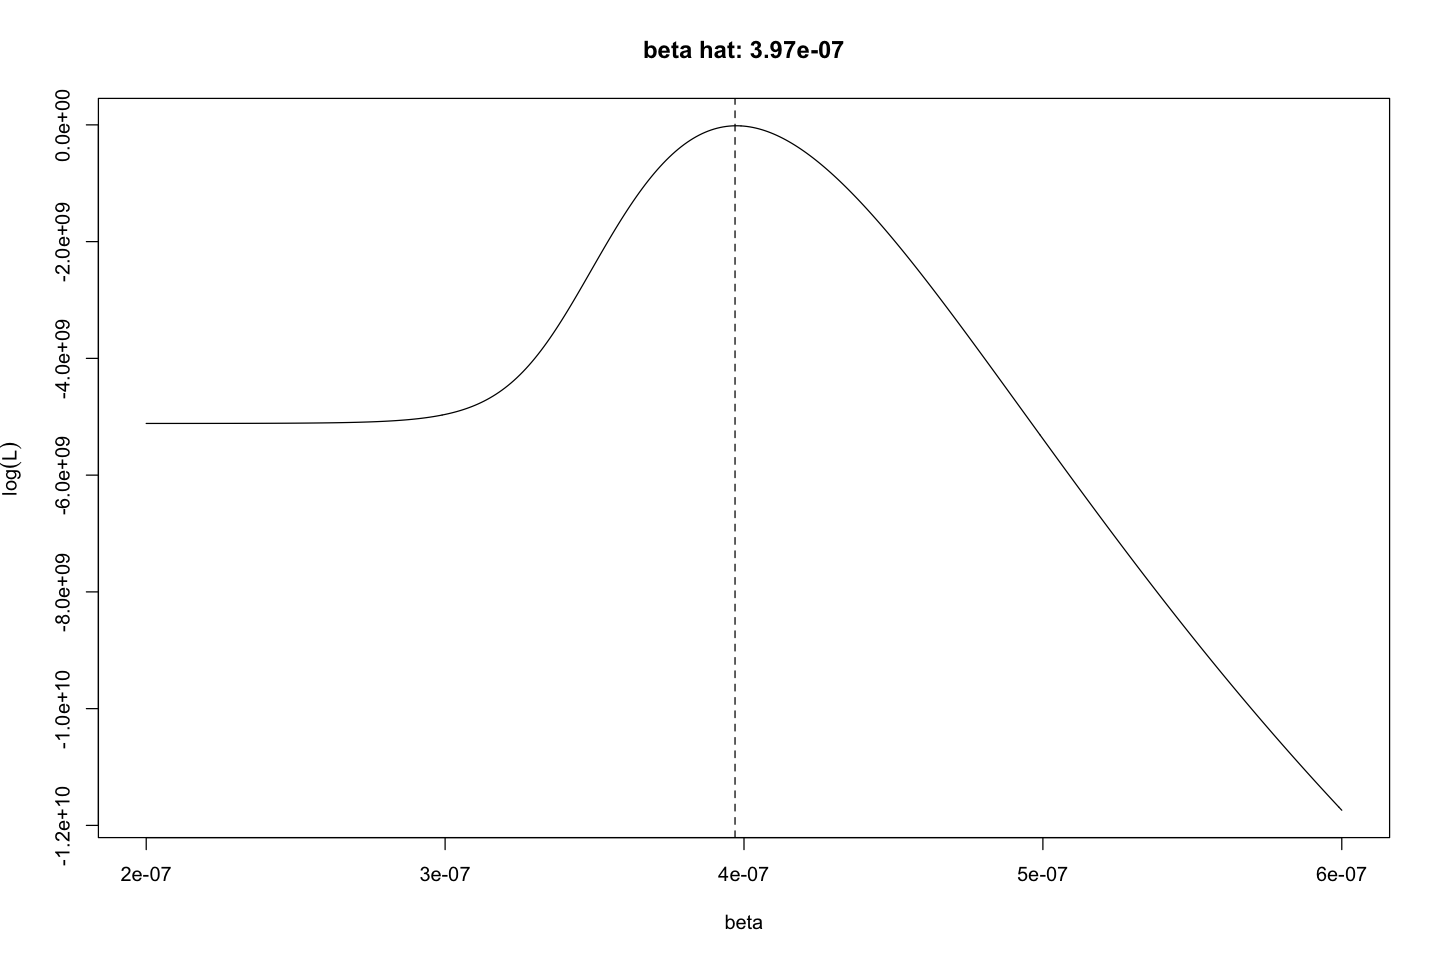

In [617]:
# plot log-likelihood as function of beta
beta <- seq(from=2e-7,to=6e-7,by=1e-9)
ll <- sapply(beta,f1)

beta.hat <- beta[which.max(ll)]
plot(beta, ll, type='l',ylab=expression(log(L)), main=paste0('beta hat: ', beta.hat))
abline(v=beta.hat,lty=2)

##### Trajectory with optimized beta

In [618]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=c(beta.hat, gamma, mu),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 29 row(s) containing missing values (geom_path).”


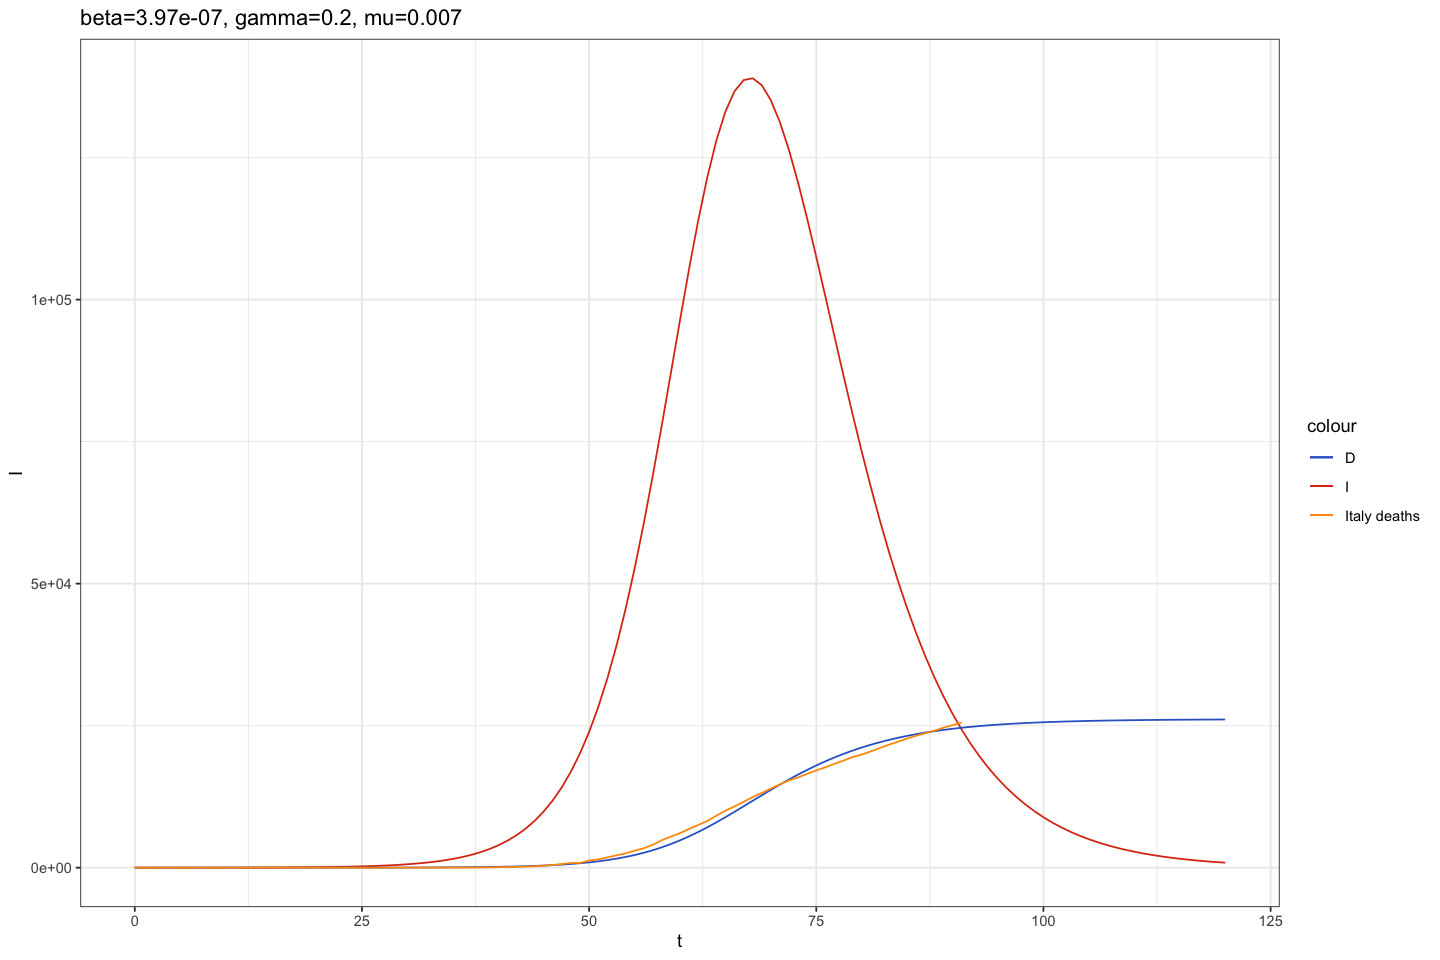

In [619]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('beta=', beta.hat, ', gamma=', gamma, ', mu=', mu))
p

## Fit 3: Normal (beta, gamma optimization)

- Maximize log-likelihood (sum of normal error)
- Optimize $\beta$ and $\gamma$ simultaneously, fixed $\mu$

##### Model

In [84]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [147]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [392]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [393]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [394]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [639]:
# log likelihood function
loglik.normal <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dnorm(x=italy$death, mean=subset(s, t >= min(italy$t) & t <= max(italy$t))$D,
              sd=params["sigma"], log=TRUE))
}

In [696]:
# parameter iterative function
f2 <- function (log.beta, log.gamma) {
    params <- c(beta=exp(log.beta), gamma=exp(log.gamma), mu=mu, sigma=sigma)
    loglik.normal(params)
}

##### Optimization

In [685]:
grid <- expand.grid(log.beta=seq(from=-14.8,to=-14.65,length=50),
                    log.gamma=seq(from=-1.7,to=-1.5,length=50)
                   )
grid$ll <- unlist(do.call(Map, c(f = f2, grid)))

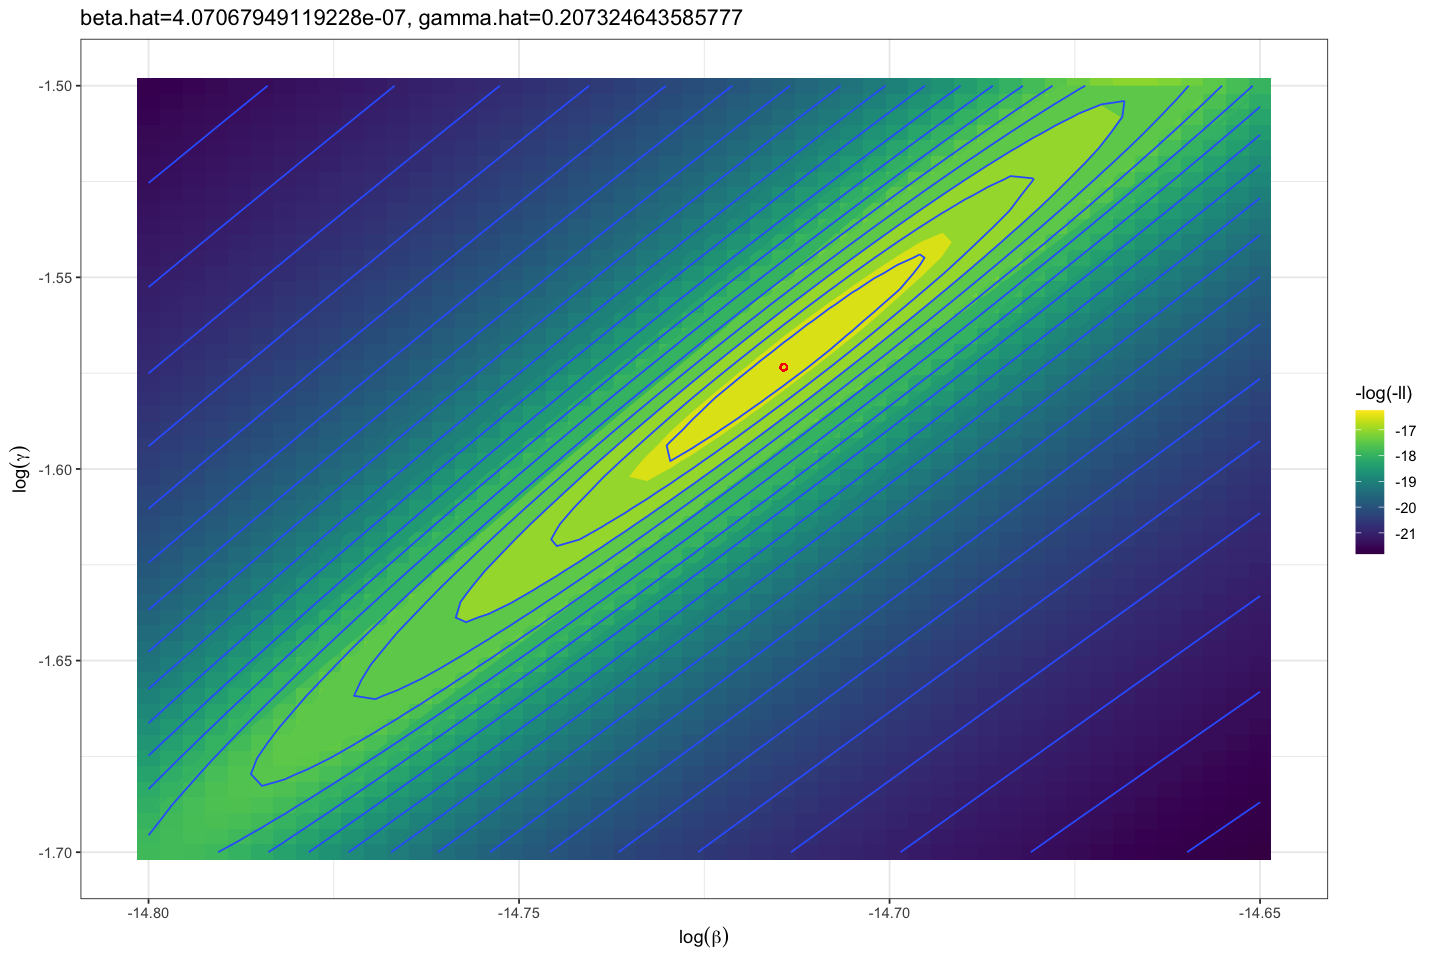

In [686]:
# Contour plot of beta and gamma

opt <- grid[which.max(grid$ll),]
beta.hat <- exp(opt$log.beta)
gamma.hat <- exp(opt$log.gamma)

p <- ggplot(grid, aes(x = log.beta, y = log.gamma, z = -log(-ll)))
p <- p + theme_bw() + scale_fill_viridis()
p <- p + geom_tile(aes(fill = -log(-ll)))
p <- p + stat_contour(geom = 'polygon', aes(fill = ..level..))
p <- p + stat_contour(bins = 20)
p <- p + xlab(expression(log(beta))) + ylab(expression(log(gamma)))
p <- p + ggtitle(paste0('beta.hat=', beta.hat, ', gamma.hat=', gamma.hat))
p <- p + geom_point(aes(x=log(beta.hat), y=log(gamma.hat)), col='red', shape=21)
p

##### Trajectory with optimized beta

In [687]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=c(beta.hat, gamma.hat, mu),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 29 row(s) containing missing values (geom_path).”


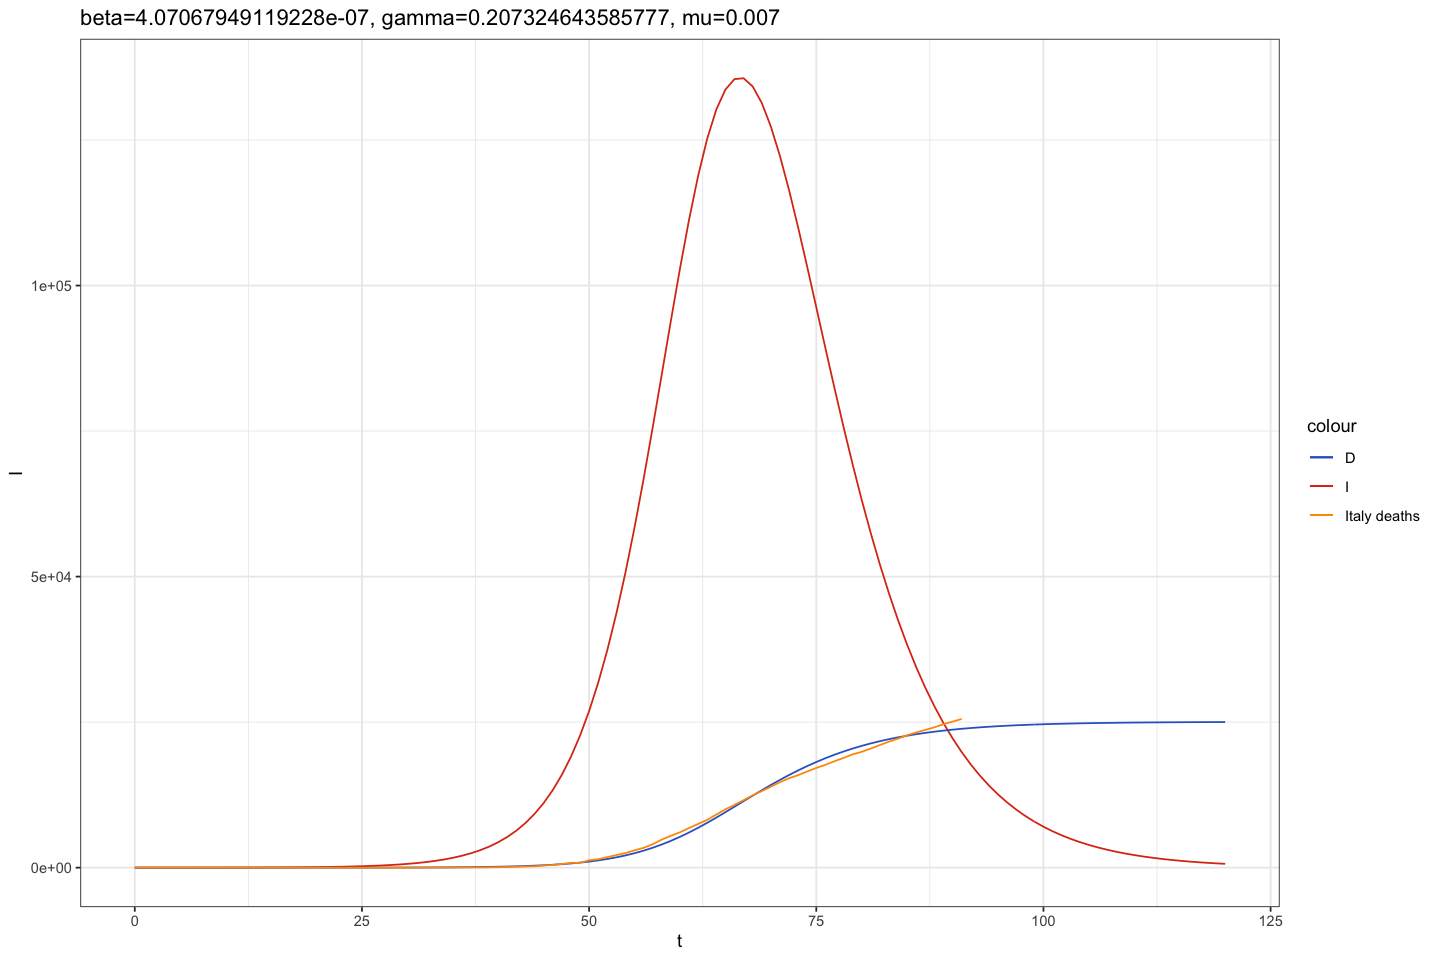

In [688]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('beta=', beta.hat, ', gamma=', gamma.hat, ', mu=', mu))
p

## Fit 4: Normal error (beta, gamma, mu)

- Maximize log-likelihood (sum of normal error)
- Optimize $\beta$, $\gamma$, and $\mu$ simultaneously

##### Model

In [689]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [690]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [691]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [743]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [744]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [745]:
# log likelihood function
loglik.normal <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dnorm(x=italy$death, mean=subset(s, t >= min(italy$t) & t <= max(italy$t))$D,
              sd=params["sigma"], log=TRUE))
}

In [746]:
# parameter iterative function

logit <- function (p) log(p/(1-p))    # the logit transform
expit <- function (x) 1/(1+exp(-x))   # inverse logit

f3 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), sigma=sigma)
    -loglik.normal(params)
}

##### Optimization

In [755]:
fit3 <- optim(f3, par=c(-15, -2, -5))
fit3

opt <- fit3$par
R0 <- exp(opt[1]) * N / exp(opt[2])

$par
[1] -15.125699  -3.419834  -6.676330

$value
[1] 385980.2

$counts
function gradient 
     308       NA 

$convergence
[1] 0

$message
NULL

##### Trajectory with optimized beta

In [749]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 29 row(s) containing missing values (geom_path).”
Warning message:
“Removed 29 row(s) containing missing values (geom_path).”
Warning message:
“Removed 29 row(s) containing missing values (geom_path).”


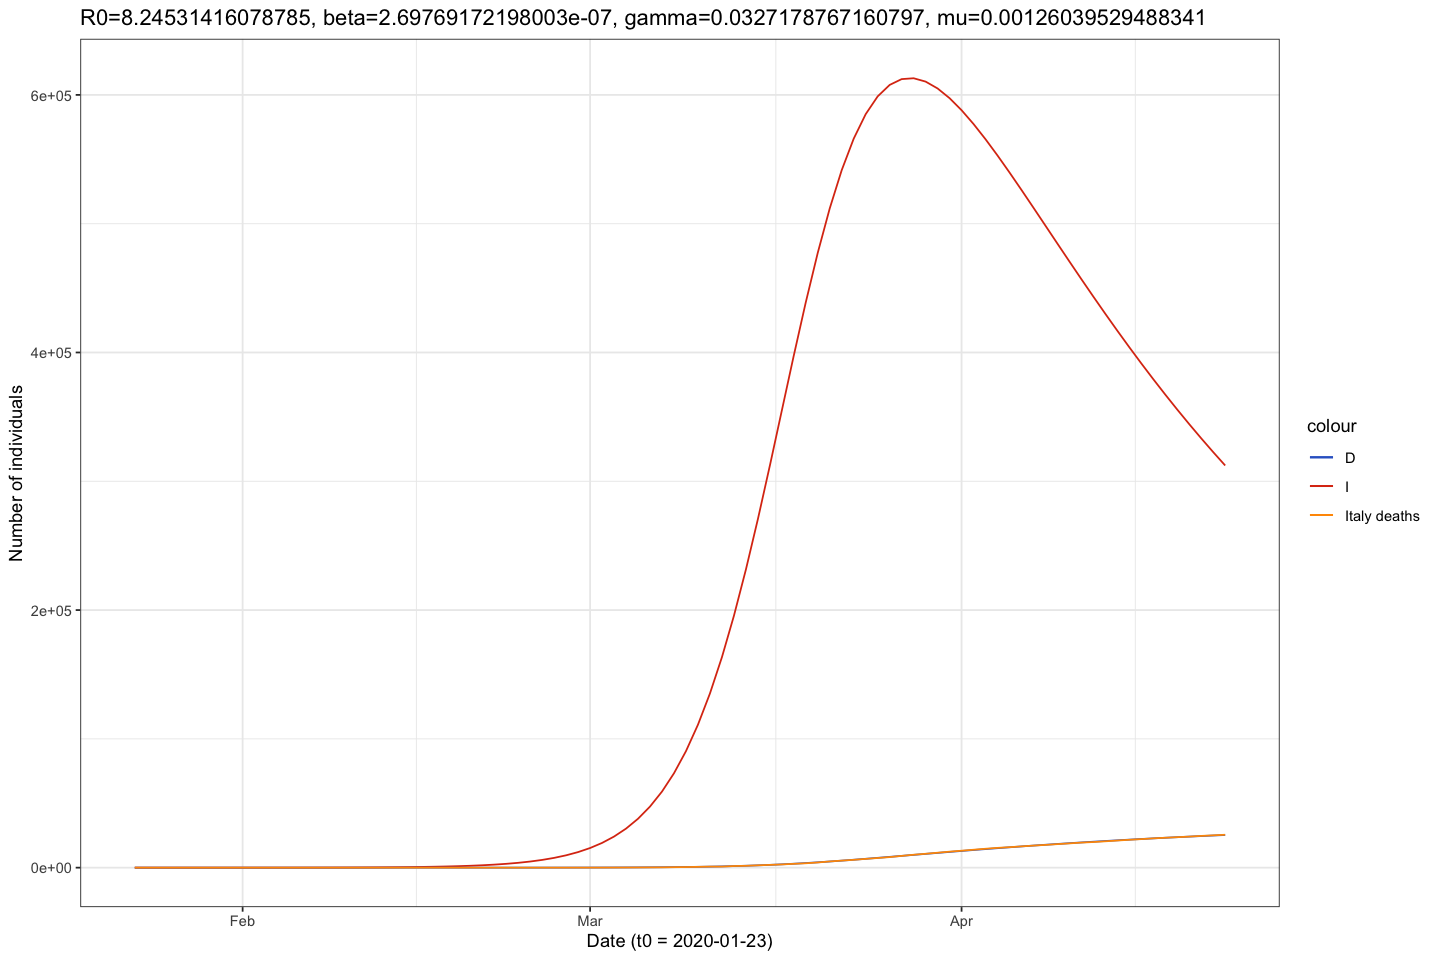

In [758]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=date))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 29 row(s) containing missing values (geom_path).”
Warning message:
“Removed 29 row(s) containing missing values (geom_path).”
Warning message:
“Removed 29 row(s) containing missing values (geom_path).”


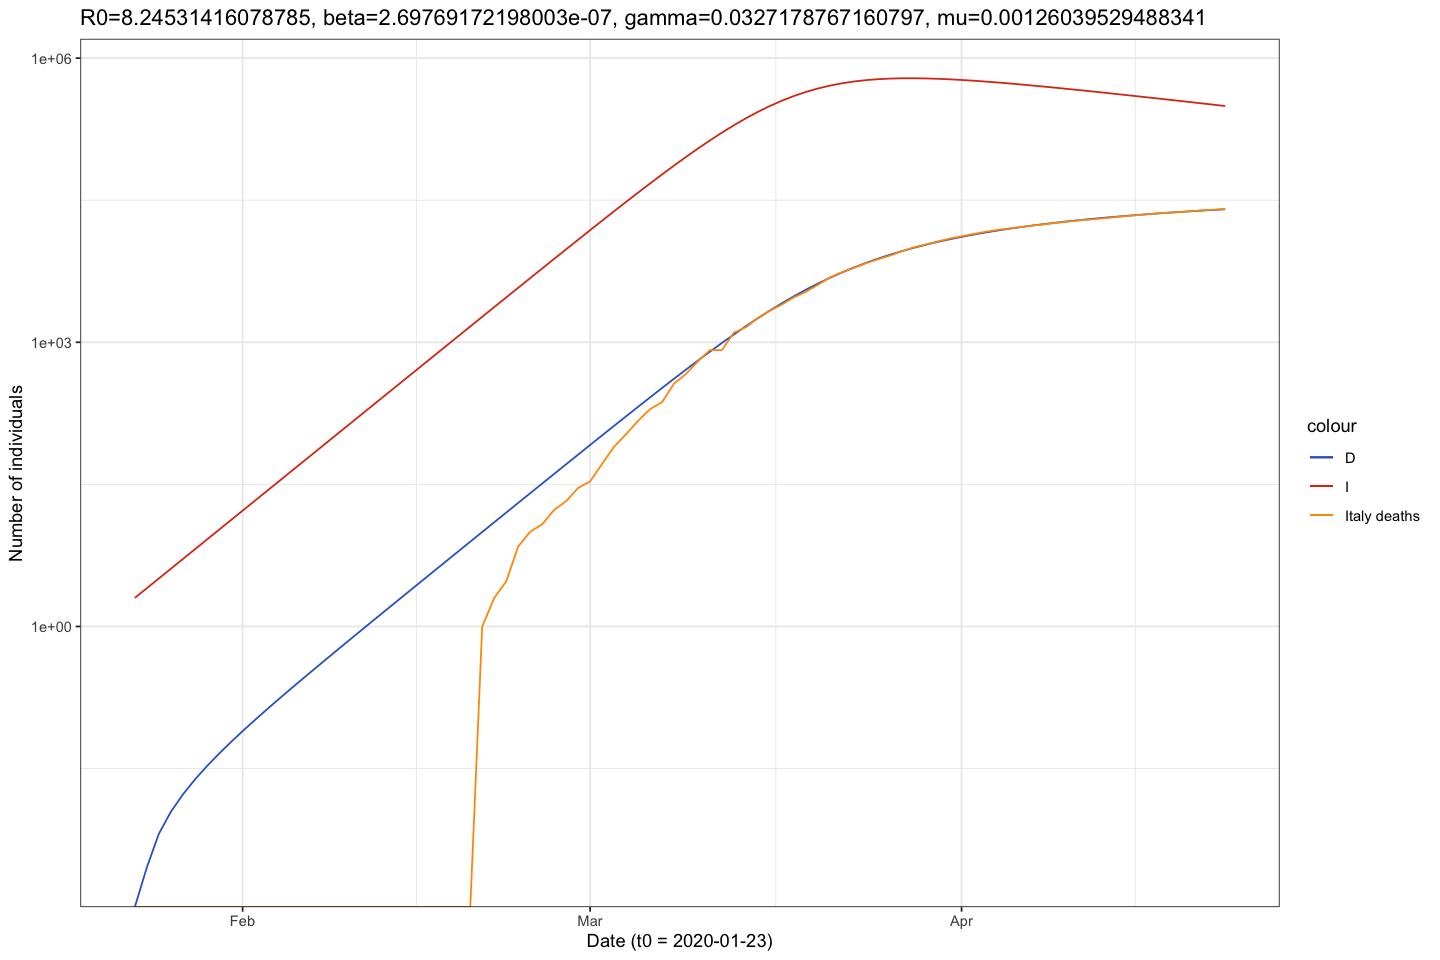

In [759]:
# plot the simulated data compared to the observed (italy) data (log transformed)
p <- ggplot(join(sim, italy, by='t'), aes(x=date))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p